In [1556]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1557]:
# change to point to the right folder on your mahchine where you cloned the Zeeguu-Core
CODE_ROOT_FOLDER = 'code/'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER

def full_path(file_name):
    return CODE_ROOT_FOLDER+file_name

In [1558]:
import sys
import pathlib
from pathlib import Path
import re
import networkx as nx
import matplotlib.pyplot as plt

In [1559]:
def LOC(file):
    return sum([1 for line in open(file)])

In [1560]:
def extract_import_from_line(line):
    # TODO: think about how to detect imports when
    # they are inside a function / method
    x = re.search("^import (\S+)", line)
    if(x == None):
        x = re.search("^from (\S+)", line)

    return x.group(1)

In [1561]:
def imports(file):
    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            all_imports.append(extract_import_from_line(line))
        except:
            continue
            
    return all_imports

assert "requests" in imports(full_path('iot-grafana-user-creator/handler.py'))

In [1562]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. /Users/mircea/Zeeguu-Core/zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'iot-grafana-user-creator.handler' == module(full_path('iot-grafana-user-creator/handler.py'))

In [1563]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.Graph()

    for file in files:
        m = module(str(file))

        if "template" not in str(file):

            if m not in G.nodes:
                G.add_node(m)

            for each in imports(str(file)):
                G.add_edge(m, each)

    return G

In [1564]:
def draw_graph(G):
    plt.figure(figsize=(10,10))
    plt.tight_layout
    nx.draw(G,with_labels=True)
    plt.show()

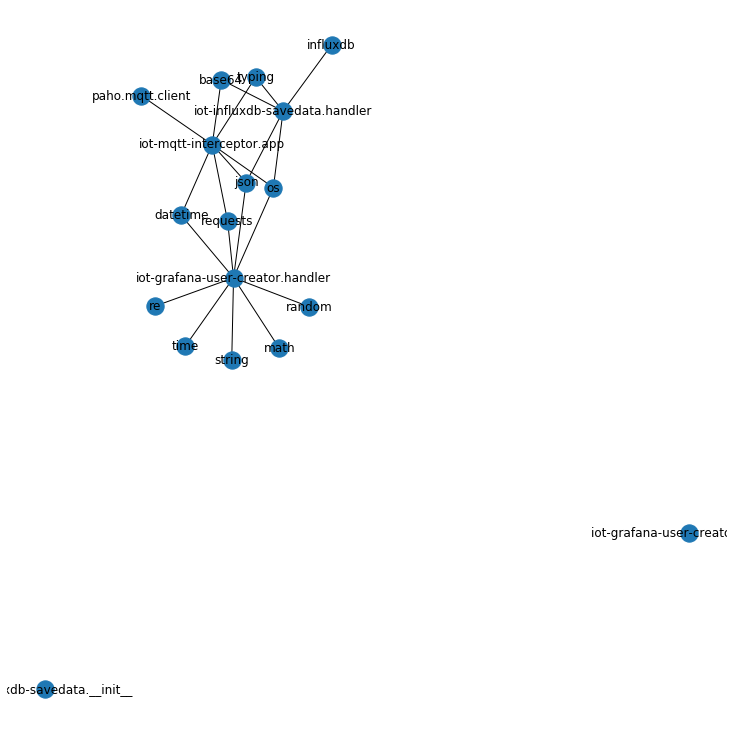

In [1565]:
G = dependencies_graph()
draw_graph(G)

# 1. Basic Abstraction: Visualization imports

In [1566]:
def top_level_module(module_name, depth=1):
    # extracts the parent of depth X 
    # e.g. top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("grafana-user-creator.helper") == "grafana-user-creator")
assert (top_level_module("grafana-user-creator.helper", 2) == "grafana-user-creator.helper")

In [1567]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))

    return aG

In [1568]:
def draw_graph_with_labels(G, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.tight_layout
    
    nx.draw(G,with_labels=True)
    
    plt.show()

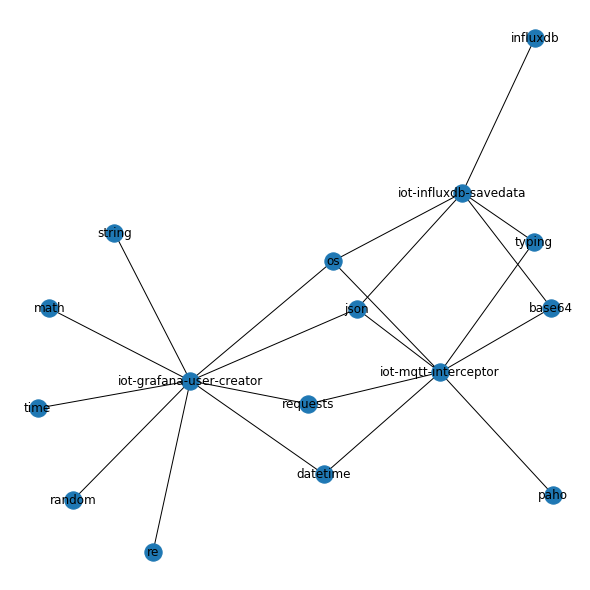

In [1569]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (8,8))

# Directed dependencies amongst internal modules

In [1570]:
def system_module(m):
    return m.startswith('iot')

In [1571]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    count = 0
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            count = count + 1
            aG.add_edge(source, destination)
            
    if count == 0: 
        print("No dependencies amongt top level modules")
        return None
    
    return aG

In [1572]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
if(aG != None): 
    draw_graph_with_labels(aG, (5,5))

No dependencies amongt top level modules


# 2. Basic Presentation: Now with architectural properties

In [1573]:
def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

print("Lines of code pr service:")
print("iot-grafana-user-creator", module_size("iot-grafana-user-creator"))
print("iot-influxdb-savedata", module_size("iot-influxdb-savedata"))
print("iot-mqtt-interceptor", module_size("iot-mqtt-interceptor"))

Lines of code pr service:
iot-grafana-user-creator 101
iot-influxdb-savedata 86
iot-mqtt-interceptor 56


In [1574]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    
    node_weights = [weight_function(each)*10 for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

In [1575]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))

    return aG

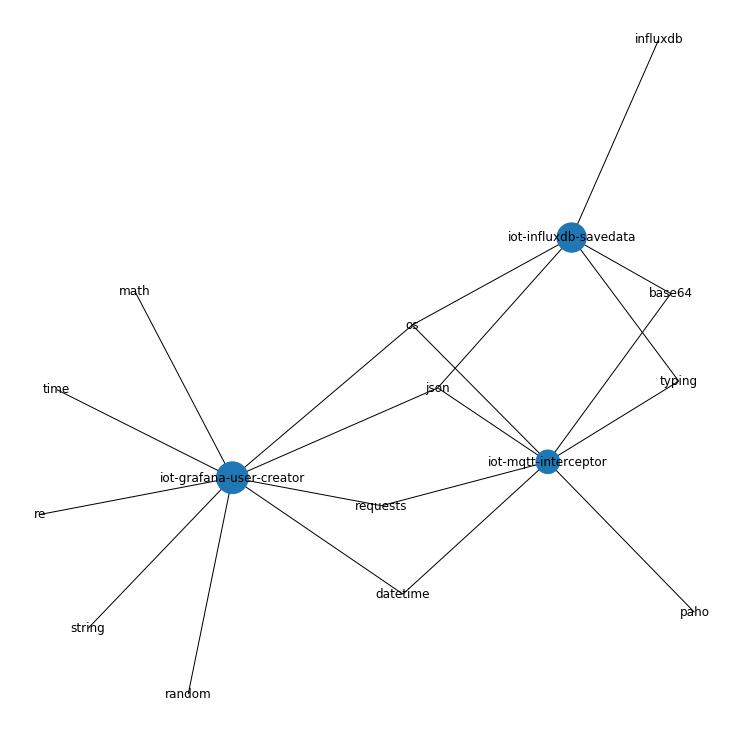

In [1576]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

This diagram shows multiple things:


    Identical services are grouped together, if we deem sercices similar if they have the same dependencis. The more semilar, the tighter they are grouped due to this actually being a chemistry representation, i wont go into detail.
    
    Shows our services, and the dependencies required to perform dynamic analysis.
    
 


# External services

In [1577]:
# change to point to the right folder on your mahchine where you cloned the Zeeguu-Core
CODE_ROOT_FOLDER = 'code/'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER

def full_path(file_name):
    return CODE_ROOT_FOLDER+file_name

In [1578]:
def extract_urls_from_line(line):
    # TODO: think about how to detect imports when
    # they are inside a function / method
    x = re.search("(https?:\/\/(.)*)", line)
    if x != None: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        if '+' not in line: # composit variable
            y = re.search("(https?:\/\/(\w.)*(\w)*.(\w){2,3})", line)
            if y.group(1) != None: 
                var_dec = y.group(1)

        print(var_name, var_dec)

    return var_name

In [1579]:
# urls in code

def imports(file):
    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            all_imports.append(extract_urls_from_line(line))
        except:
            continue
            
    return all_imports

print("MQTT-INTERCEPTOR")
assert "gateway_url" in imports(full_path('iot-mqtt-interceptor/app.py'))
print()

print("IOT-GRAFANA-USER-CREATOR")
assert "URL_USERS" in imports(full_path('iot-grafana-user-creator/handler.py'))
print()

print("IOT-INFLUXDB-SAVEDATA")
#assert "INFLUXDB_ADDRESS" in imports(full_path('iot-influxdb-savedata/handler.py'))
print()


MQTT-INTERCEPTOR


AssertionError: 

In [1551]:
def extract_urls_from_env_line(line):
    # TODO: think about how to detect imports when
    # they are inside a function / method
    x = re.search("(\w)*:(\w)*", line)
    if x != None: 
        var_name = line.split(": ")[0].strip()
        var_dec = line.split(": ")[1].strip()
        
        # full url
        #y = re.search("(https?:\/\/(\w.)*(\w)*.(\w){2,3})", line)
        y = re.search("([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])?", line)

        if y.group(1) != None: 
            var_dec = y.group(1)
            #print(var_name, var_dec)

    return var_name

In [1552]:
# urls in environment variables

# For this prototype, we analyse OpenFaas yaml file

def env_vars(file):
    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            if 'version' in line: 
                continue
            all_imports.append(extract_urls_from_env_line(line))
        except:
            continue
            
    return all_imports

print("iot-savedata")
assert "gateway" in env_vars(full_path('iot-influxdb-savedata/iot-assignment2.yml'))
assert "influx_host" in env_vars(full_path('iot-influxdb-savedata/iot-assignment2.yml'))
print()

print("iot-grafana-user")
assert "gateway" in env_vars(full_path('iot-grafana-user-creator/iot-assignment2.yml'))
assert "host" in env_vars(full_path('iot-grafana-user-creator/iot-assignment2.yml'))
print()

#print("iot-mqtt-interceptor")
#assert "gateway_url" in env_vars(full_path('iot-mqtt-interceptor/app.py'))


iot-savedata

iot-grafana-user



# CAA

In the following section we will determine the external dependencies of the OpenFaas functions in the repository

## OpenFaas

#### Environment variables 

In [1518]:
def extract_env_from_line(line):
    x = re.search("(\w)*:(\w)*", line)
    if x != None: 
        var_name = line.split(": ")[0].strip()
        var_dec = line.split(": ")[1].strip()

    return (var_name, var_dec)

This extacts env vars from yml structure

In [1519]:
def map_env_vars_openfaas(handler, env_vars):
    print("Parsing", "'" + handler + "'", "and replacing variables...")
    lines = [line for line in open(handler)]
    
    all_vars = []
    for line in lines:
        try:
            for (k, v) in env_vars:
                if k in line:
                    print("Replacing", "os.getenv(\"" + k + "\")", "with", v)
                    line = line.replace("os.getenv(\"" + k + "\")", v, 1)
                
            all_vars.append(line)
        except:
            continue
            
    return all_vars


def get_env_vars_openfaas(yml):
    print("Parsing", "'" + yml + "'", "for environment variables...")
    lines = [line for line in open(yml)]
    
    all_vars = []
    for line in lines:
        try:
            # skip attributes we don't care about for now
            if 'image' in line:
                continue
            if 'name' in line:
                continue
            if 'lang' in line:
                continue
            if 'handler' in line:
                continue
            if 'version' in line: 
                continue
                
            all_vars.append(extract_env_from_line(line))
            
        except:
            continue
        
    print("Environment variables:", all_vars)
    return all_vars

def get_program_text_with_env_openfaas(yml, handler):
    env_vars = get_env_vars_openfaas(full_path(yml))
    return map_env_vars_openfaas(full_path(handler), env_vars)


This returns a map with the env variables.

Use like this to obtain new source code with environment varibales substituted

```
get_program_with_env_openfaas('iot-influxdb-savedata/iot-assignment2.yml', 'iot-influxdb-savedata/handler.py')
```

At this point the code contains the variables otherwise normally only obtianed at runtime. Lets see if we can figure out which external services the service is communicating with.

### Replace environment variables in code

In [1520]:
def extract_urls_from_line(line):
    # filter initial source code lines so only one with variables remains
    matching = re.search("(https?:\/\/(.)*)", line)
    
    if matching != None or 'ec2' in line: # not https?:// format, or contains ec2 for aws
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        # refine if not composite variable
        if '+' not in line: 
            y = re.search("((https?:\/\/)?[-\w.]*(\.\w{2,3}(:?[\d]{2,6})?))", line)
            if y.group(1) != None: 
                var_dec = y.group(1)

        print("    >", var_name, var_dec)

    return (var_name, var_dec)

def find_external_services(program):
    lines = [line for line in program]
    
    services = []
    for line in lines:
        try:
            # extract lines with urls
            services.append(extract_urls_from_line(line))
        except:
            continue
    
    print()
    print("Found", len(services), "external services")
    return services


def interpret_service_strings(env_vars):
    interpreted = []
    for line in env_vars:
        try:
            for (k, v) in env_vars:
                if k in line[1]:
                    print("Replacing", k, "with", v)
                    # clean up string
                    tmp = line[1].replace(k, v, 1)
                    tmp = tmp.strip().replace("'", "")
                    tmp = tmp.replace("+", "")
                    res = tmp.replace(" ", "")

            # only modified values
            interpreted.append((line[0], res))
            
        except:
            continue
            
    print("Changed", len(interpreted), "values by substitution", "\n")
    return interpreted


def analyse_external_services(yml, handler):
    services = find_external_services(
        get_program_text_with_env_openfaas(
            yml, 
            handler))
    
    changed = interpret_service_strings(services)

    # combine lists to one, or return env if no changes
    if len(changed) > 0:
        list1, list2 = zip(*changed)
        for(k,v) in services:
            if k in list1:
                continue
            else: 
                changed.append((k, v))
        return changed

    else: 
        return services


print()
print("Analysing IOT-Grafana-user-creator...\n")
external_dependencies_grafana = analyse_external_services('iot-grafana-user-creator/iot-assignment2.yml', 'iot-grafana-user-creator/handler.py')
print("Results for IOT-Grafana-user-creator:")
for (k,v) in external_dependencies_grafana:
    print("  ", k+":", v)

print()
print()
print()
print()

print("Analyzing IOT-InfluxDB-SaveData...\n")
external_dependencies_influx = analyse_external_services('iot-influxdb-savedata/iot-assignment2.yml', 'iot-influxdb-savedata/handler.py')
print("Results for IOT-InfluxDB-SaveData:")
for (k,v) in external_dependencies_influx:
    print("  ", k+":", v)

print()
print()



Analysing IOT-Grafana-user-creator...

Parsing 'code/iot-grafana-user-creator/iot-assignment2.yml' for environment variables...
Environment variables: [('gateway', 'https://gateway.christoffernissen.me'), ('host', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000')]
Parsing 'code/iot-grafana-user-creator/handler.py' and replacing variables...
Replacing os.getenv("host") with ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > HOST ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > URL_USERS 'http://admin:smartmeter@' + HOST + '/api/admin/users'
    > URL_DASHBOARD 'http://' + HOST + '/api/dashboards/db'
    > URL_DASHBOARD_PERMISSIONS 'http://' + HOST + '/api/dashboards/id/%s/permissions'
    > URL_CUSTOMERS_TEAM_MEMBERS 'http://' + HOST + '/api/teams/10/members'

Found 5 external services
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws

Now we have an overview of the OpenFaas functions. In the following section the same will be calculated for the docker container service MQTT-Interceptor. 

Finally, we will visualize the different services, and the links between services.

## Docker service

In [1521]:
def extract_env_from_line_docker(line):
    x = re.search("(\w)*=(\w)*", line)
    if x != None: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()

    return (var_name, var_dec)

env file parsed

In [1522]:
def map_env_vars_docker(handler, env_vars):
    print("Parsing", "'" + handler + "'", "and replacing variables...")
    lines = [line for line in open(handler)]
    
    all_vars = []
    for line in lines:
        try:
            for (k, v) in env_vars:
                if k in line:
                    if 'os.getenv' in line: 
                        print("    Replacing", "os.getenv(\"" + k + "\")", "with", v)
                        line = line.replace("os.getenv(\"" + k + "\")", v, 1)
                    else: 
                        print("    Replacing", k, "with", v)
                        line = line.replace(k, v, 1)
                        line.replace("+", "")
                          
                all_vars.append(line)
        except:
            continue
            
    return all_vars

def get_env_vars_docker(env):
    print("Parsing", "'" + env + "'", "for environment variables...\n")
    lines = [line for line in open(env)]
    
    all_vars = []
    for line in lines:
        try:
            all_vars.append(extract_env_from_line_docker(line))
            
        except:
            continue
        
    print("Environment variables:\n", all_vars)
    return all_vars

def get_program_text_with_env_docker(env, code):
    env_vars = get_env_vars_docker(full_path(env))
    return map_env_vars_docker(full_path(code), env_vars)


at this point we have modified the source code so it now is substituted with env vars

In [1523]:
def extract_urls_from_line_docker(line):
    # filter initial source code lines so only one with variables remains
    x = re.search("(https?:\/\/(.)*)", line)
    
    if x != None or 'ec2' in line: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        # refine if not composite variable
        if '+' not in line: 
            y = re.search("((https?:\/\/)?[-\w.]*(\.\w{2,3})(:[\d]{4})?)", line)
            if y.group(1) != None: 
                var_dec = y.group(1)
                
    return (var_name, var_dec.replace("+", " ").replace(" ", "").replace("\"", ""))

def find_external_services_docker(program):
    lines = [line for line in program]
    
    services = []
    for line in lines:
        try:
            services.append(extract_urls_from_line_docker(line))
        except:
            continue
    
    print()
    print("Found", len(services), "external services\n")
    return services


def analyse_external_services_docker(yml, handler):
    mod_program = get_program_text_with_env_docker(
            yml, 
            handler)
    
    services = find_external_services_docker(mod_program)
    
    return services


print()
print("IOT-MQTT-INTERCEPTOR")
print()
external_dependencies_mqtt = analyse_external_services_docker('iot-mqtt-interceptor/env_vars', 
            'iot-mqtt-interceptor/app.py')
print("Results:")
for (k,v) in external_dependencies_mqtt:
    print("  ", k+":", v)
    
# now we have all external dependencies, including our own functions. Lets identify those:

funcs = []
print("Identified following dependencies on OpenFaas Functions")
for (k,v) in external_dependencies_mqtt:
    if '/function/' in v:
        func = v.split("/")[len(v.split("/"))-1]
        print("  ", func)
        funcs.append(func)
         
print()
print()



IOT-MQTT-INTERCEPTOR

Parsing 'code/iot-mqtt-interceptor/env_vars' for environment variables...

Environment variables:
 [('gateway_url', 'https://gateway.christoffernissen.me')]
Parsing 'code/iot-mqtt-interceptor/app.py' and replacing variables...
    Replacing os.getenv("gateway_url") with https://gateway.christoffernissen.me
    Replacing gateway_url with https://gateway.christoffernissen.me
    Replacing gateway_url with https://gateway.christoffernissen.me

Found 2 external services

Results:
   gateway_url: https://gateway.christoffernissen.me
   function_url: https://gateway.christoffernissen.me/function/iot-influxdb-savedata-func
Identified following dependencies on OpenFaas Functions
   iot-influxdb-savedata-func




Puhhh. Thats it. We have identified the external dependencies, and also identifed our our functions. We can now use the information to graw diagrams. 

OpenFaas functions will be represented as nodes with the directory name, and non-OpenFaas dependencies will just be mapped to a node where the nodes label is the value, and the edge label is the env var name. 